# Проект "Назовём попозже"

Цель нашего проекта - понять как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах. 

### Изучение общих и сырых поступивших данных

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
from scipy import stats as st
import plotly.graph_objects as go

# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

data = pd.read_csv('/datasets/logs_exp.csv', sep='\t', low_memory=False)
data

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


Мы вывели датасет с 244126 логами бинарного типа. В нашем логе указано:
 - название события
 - id пользователя
 - время события
 - номер эксперимента, где 246 и 247 — контрольные группы, а 248 — экспериментальная.

# 2. Подготовка и обработка данных

### Заменим названия столбцов на удобные для нас.

In [2]:
# Правило хорошего стиля. (Либо с заглавной, либо нижним подчеркиванием)
data = data.rename(columns={'DeviceIDHash': 'UserId', 'EventTimestamp': 'EventTimeStamp'})
data

,EventName,UserId,EventTimeStamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


Вот так вот мы поменяли название наших столбцов.

### Проверим пропуски и типы данных.

In [3]:
# Проверка типа данных
print(data.info())

# Проверка количества пропущенных значений
print("Пропущенные значения в EventName:")
print(data['EventName'].isnull().sum())
print("\nПропущенные значения в UserId:")
print(data['UserId'].isnull().sum())
print("\nПропущенные значения в EventTimeStamp:")
print(data['EventTimeStamp'].isnull().sum())
print("\nПропущенные значения в ExpId:")
print(data['ExpId'].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   UserId          244126 non-null  int64 
 2   EventTimeStamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None
Пропущенные значения в EventName:
0

Пропущенные значения в UserId:
0

Пропущенные значения в EventTimeStamp:
0

Пропущенные значения в ExpId:
0


В нашем датафрейме пропущенных значений нет. 

Типы данных в датафрейме: 
 - EventName - object
 - Остальные столбцы - int64

#### Добавим столбцы даты и времени, а также выведем отдельный столбец с датами.

In [4]:
# Преобразуем столбец с временной меткой в datetime формат и добавляем новые столбцы
data['EventTimeStamp'] = pd.to_datetime(data['EventTimeStamp'], unit='s')
data['event_date'] = data['EventTimeStamp'].astype('datetime64[D]')
data

,EventName,UserId,EventTimeStamp,ExpId,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


Теперь мы ясно видим дату и время события, а также мы добавили новый столбец с датами. 

#### Выясним, есть ли дубликаты в столбце EventTimeStamp

In [5]:
# Найдем дубликаты по столбцу EventTimeStamp
duplicates_time = data[data['EventTimeStamp'].duplicated(keep=False)]

# Найдем полные дубликаты по всем столбцам
full_duplicates = data[data.duplicated(keep=False)]

# Вывести все строки, где время события повторяется
if not duplicates_time.empty:
    print("Действия, совершенные в одну и ту же секунду:")
    print(duplicates_time.head(10))
else:
    print("Нет действий, совершенных в одну и ту же секунду.")

if not full_duplicates.empty:
    print("\nПолные дубликаты:")
    print(full_duplicates.head(10))
else:
    print("\nНет полных дубликатов.")

Действия, совершенные в одну и ту же секунду:
                  EventName               UserId      EventTimeStamp  ExpId  \
2   PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:28:47    248   
3          CartScreenAppear  3518123091307005509 2019-07-25 11:28:47    248   
27         CartScreenAppear  2029140728621466572 2019-07-26 17:06:41    246   
28  PaymentScreenSuccessful  2029140728621466572 2019-07-26 17:06:41    246   
35  PaymentScreenSuccessful   746235405686708560 2019-07-26 19:44:26    248   
36         CartScreenAppear   746235405686708560 2019-07-26 19:44:26    248   
37         CartScreenAppear  6805714022805866600 2019-07-26 19:44:27    246   
38  PaymentScreenSuccessful  6805714022805866600 2019-07-26 19:44:27    246   
42  PaymentScreenSuccessful  6075091495307260046 2019-07-27 06:41:05    246   
43         CartScreenAppear  6075091495307260046 2019-07-27 06:41:05    246   

   event_date  
2  2019-07-25  
3  2019-07-25  
27 2019-07-26  
28 2019-07-26  
35 2

In [6]:
full_duplicates

,EventName,UserId,EventTimeStamp,ExpId,event_date
452,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248,2019-07-30
453,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248,2019-07-30
2348,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248,2019-07-31
2350,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248,2019-07-31
3572,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248,2019-08-01
...,...,...,...,...,...
242359,PaymentScreenSuccessful,2382591782303281935,2019-08-07 19:27:29,246,2019-08-07
242360,PaymentScreenSuccessful,2382591782303281935,2019-08-07 19:27:29,246,2019-08-07
242362,CartScreenAppear,2382591782303281935,2019-08-07 19:27:29,246,2019-08-07
242634,MainScreenAppear,4097782667445790512,2019-08-07 19:36:58,246,2019-08-07


Итого полных дубликатов: 768 строки. 

Да, мы видим, что у нас есть случаи, где одни пользователи совершали разные действия в одну и ту же секунду. Баг это или логика выгрузки данных странная, либо у нас самые быстрые кликеры-пользователи на диком Западе, это предстоит выяснить (но не в этой работе). 
В нашем случае, я думаю, что нужно оставить пока эти данные. Потому что в дальнейшем мы будем урезать даты и высчитывать аномальные выбросы. 

#### Проверим корректно ли поделились пользователи в группы 246, 247, 248 и B и нет ли тех кто попал и в одну и в другую группу.

In [7]:
group_246_visitors = set(data[data['ExpId'] == '246']['ExpId'])
group_247_visitors = set(data[data['ExpId'] == '247']['ExpId'])
group_248_visitors = set(data[data['ExpId'] == '248']['ExpId'])

# Поиск пересечений между группами
common_visitors = group_246_visitors.intersection(group_247_visitors, group_248_visitors)

# Проверка наличия пересечений и вывод результатов
if common_visitors:
    print("Пользователи, попавшие во все 3 группы:", common_visitors)
else:
    print("Нет пересечений между группами 246, 247, 248. Распределение верное")

Нет пересечений между группами 246, 247, 248. Распределение верное


# 3. Изучение и проверка данных 

#### Сколько всего событий в логе?

Поскольку в датасете каждая строка обозначает определенное событие в логе, то начиная с 2019-07-25 04:43:36 по 2019-08-07 21:15:17, собыий в логе 244125.

#### Сколько всего пользователей в логе?

In [8]:
# Выведем новую переменную, обозначающую кол-во уникальных пользователей в нашем датасете. 
unique_UserId = data['UserId'].nunique()
unique_UserId

7551

Пользователей всего в логе - 7551. 

#### Сколько в среднем событий приходится на пользователя?

In [9]:
# Подсчитаем общее количество событий
total_events = data.shape[0]

# Подсчитаем количество уникальных пользователей
unique_UserId = data['UserId'].nunique()

# Рассчитаем среднее количество событий на пользователя
average_events_per_user = total_events / unique_UserId

average_events_per_user

32.33028737915508

Итак, в среднем на пользователя приходятся порядка 32-33 событий.

#### Создадим переменную с данными о количестве действий на каждого пользователя.

In [10]:
# Подсчет количества действий, совершенных каждым пользователем
events_by_users = data.groupby('UserId').size()

# Вывести первые несколько строк результата
print(events_by_users)

UserId
6888746892508752         1
6909561520679493         5
6922444491712477        47
7435777799948366         6
7702139951469979       137
                      ... 
9217594193087726423      9
9219463515465815368     17
9220879493065341500      7
9221926045299980007      7
9222603179720523844     59
Length: 7551, dtype: int64


**Декомпизируем вопрос с периодом данных:**
 - Найдем максимальную и минимальную дату
 - Изучим как меняется количество данных в разрезе группы с помощью диаграммы
 - Убедимся о полноте и схожести данных за период
 - В связи с тем, что в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого, то нам нужно определить с какого момента у нас будут истинно полные данные
 - Выясним много пользователей мы потеряли, отбросив старые данные
 - Убедимся в наличии всех трех эксперементальных групп.

In [11]:
# Найдем минимальную и максимальную дату
min_date = data['EventTimeStamp'].min()
max_date = data['EventTimeStamp'].max()

print(min_date)
print(max_date)

2019-07-25 04:43:36
2019-08-07 21:15:17


Минимальная дата - 2019-07-25 04:43:36
Максимальная дата - 2019-08-07 21:15:17

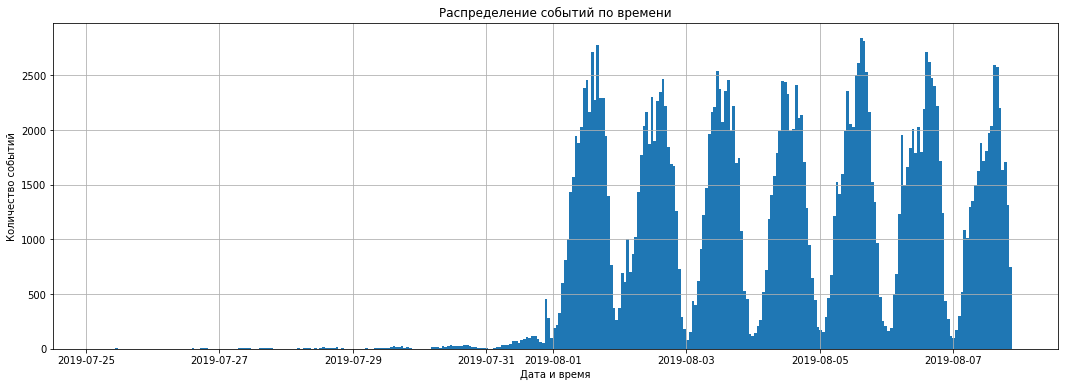

In [12]:
# Найдем доступный период данных
plt.figure(figsize=(18, 6))

data['EventTimeStamp'].hist(bins=14*24)

# Добавить подписи и заголовок
plt.xlabel('Дата и время')
plt.ylabel('Количество событий')
plt.title('Распределение событий по времени')

# Показать график
plt.show()

Вывод напрашивается сам собой. 
Мы будем использовать данные от 2019-08-01 по 2019-08-08

Построим точечный график событий на пользователя.

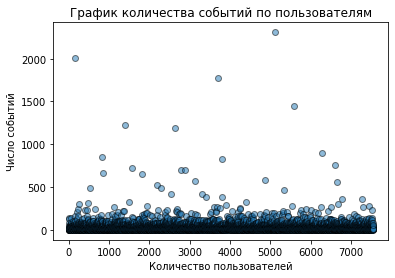

In [13]:
# Теперь строим точечный график 
events_per_user = data.groupby('UserId')['EventName'].count().reset_index()

# Переименовываем столбцы для удобства
events_per_user.columns = ['UserId', 'event_count']

# Создаем серию значений для оси X
x_values = pd.Series(range(0, len(events_per_user['event_count'])))

# Строим точечный график
plt.scatter(x_values, events_per_user['event_count'], alpha=0.5, edgecolor='k')

# Добавляем заголовок
plt.title('График количества событий по пользователям')

# Добавляем подписи осей
plt.xlabel('Количество пользователей')
plt.ylabel('Число событий')

# Отображаем график
plt.show()

Видим бо-о-о-льшие некторые выбросы. 

In [14]:
# Выявим перцентили на количество событий на пользователя 
np.percentile(events_by_users, [90,95,99])

array([ 64. ,  89. , 200.5])

Не более 5% пользователей совершают 89 событий. 
И не более 1% пользователей совершает > 200 событий. 

Возможно это технические работники/тестировщики, а может быть наши магазин находится на диком Западе и поэтому там все так быстро 🐎

Пройдемся по предыдущим шагам снова, только теперь с обновленными данными.

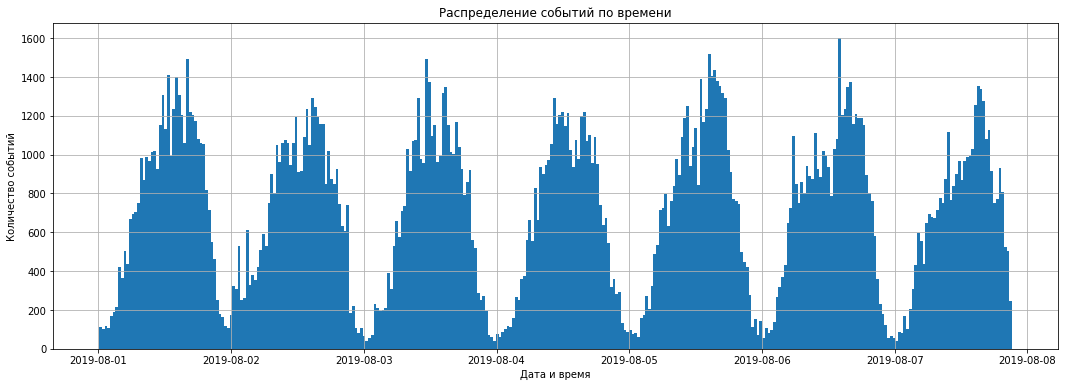

In [15]:
# Фильтрация по датам: с 2019-08-01 по 2019-08-08
start_date = '2019-08-01'
end_date = '2019-08-08'
filtered_data = data[(data['EventTimeStamp'] >= pd.to_datetime(start_date)) & 
                     (data['EventTimeStamp'] <= pd.to_datetime(end_date))]

# Найдем доступный период данных
plt.figure(figsize=(18, 6))

filtered_data['EventTimeStamp'].hist(bins=14*24)

# Добавить подписи и заголовок
plt.xlabel('Дата и время')
plt.ylabel('Количество событий')
plt.title('Распределение событий по времени')

# Показать график
plt.show()

Обновленный график нам показывает уже более детальную информацию. 

#### Выясним как много пользователей мы потеряли, отбросив ненужные данные.

Чтобы выяснить, сколько событий и пользователей было потеряно после фильтрации данных (удаления событий за пределами 2019-08-01 — 2019-08-08), можно сравнить количество событий и пользователей до и после фильтрации.

In [16]:
# Подсчитаем количество событий до фильтрации
total_events_before = len(data)
# Подсчитаем количество событий после фильтрации
total_events_after = len(filtered_data)

# Подсчитаем количество уникальных пользователей до фильтрации
unique_users_before = data['UserId'].nunique()
# Подсчитаем количество уникальных пользователей после фильтрации
unique_users_after = filtered_data['UserId'].nunique()

# Вычислим разницу в количестве событий и пользователей
events_lost = total_events_before - total_events_after
users_lost = unique_users_before - unique_users_after

# Рассчитаем процент потерь
percent_events_lost = (events_lost / total_events_before) * 100
percent_users_lost = (users_lost / unique_users_before) * 100

# Выведем результаты
print(f"Потеряно событий: {events_lost} ({percent_events_lost:.2f}%)")
print(f"Потеряно пользователей: {users_lost} ({percent_users_lost:.2f}%)")

Потеряно событий: 2828 (1.16%)
Потеряно пользователей: 17 (0.23%)


Потеряно 1,16% событий за недельный срок. 
Это не критично.

Как и 0,23% пользователей.

#### Проверим, что у нас есть пользователи всех трех эксперементальных групп.

In [17]:
filtered_data['ExpId'].unique()

array([246, 247, 248])

Все три эксперементальные группы сохранены в нашем датафрейме. 

# 4. Изучение воронки событий 

1. Изучим, какие события есть в наших логах и как часто они встречаются. 

In [18]:
filtered_data['EventName'].unique()

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

В нашем логе есть такие события как: 
 - Tutorial
 - MainScreenAppear
 - OffersScreenAppear
 - CartScreenAppear
 - PaymentScreenSuccessful

In [19]:
event_counts = filtered_data['EventName'].value_counts()
event_counts

MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: EventName, dtype: int64

Событие 
MainScreenAppear встречается 117431 раз   
OffersScreenAppear встречается 46350 раз  
CartScreenAppear встречается 34113 раз  
PaymentScreenSuccessful встречается 21374 раз
Tutorial встречается 1039 раз

In [20]:
final_data = filtered_data

2. Теперь узнаем сколько пользователей совершали каждое из этих событий 

In [21]:
import pandas as pd

# Список интересующих событий
events_of_interest = [
    'MainScreenAppear',
    'OffersScreenAppear',
    'CartScreenAppear',
    'PaymentScreenSuccessful'
]

# Подсчитаем количество уникальных пользователей для каждого события
users_per_event = final_data[final_data['EventName'].isin(events_of_interest)].groupby('EventName')['UserId'].nunique()

# Подсчитаем количество событий для каждого события
events_count = final_data[final_data['EventName'].isin(events_of_interest)]['EventName'].value_counts()

# Создадим DataFrame с этими данными
result_df = pd.DataFrame({
    'event_name': events_count.index,
    'number_of_events': events_count.values,
    'number_of_users': users_per_event.loc[events_count.index].values
})

# Рассчитаем дополнительные столбцы
total_users = final_data['UserId'].nunique()
result_df['share_of_users'] = (result_df['number_of_users'] / total_users * 100).round(2).astype(str) + '%'

# Рассчитаем процент начального и предыдущего события
result_df['percent_initial'] = (result_df['number_of_users'] / total_users * 100).round(2).astype(str) + '%'
result_df['percent_previous'] = (result_df['number_of_users'] / result_df['number_of_users'].shift(1) * 100).round(2).astype(str) + '%'

# Заполняем NaN значениями для первого события
result_df.loc[0, 'percent_previous'] = '100%'

# Форматируем столбцы с числами для удобства
result_df['number_of_events'] = result_df['number_of_events'].apply(lambda x: f'{x:,}')
result_df['number_of_users'] = result_df['number_of_users'].apply(lambda x: f'{x:,}')

# Отсортируем по количеству пользователей
result_df = result_df.sort_values(by='number_of_users', ascending=False).reset_index(drop=True)

# Выводим итоговую таблицу
print(result_df)
import pandas as pd

# Список интересующих событий
events_of_interest = [
    'MainScreenAppear',
    'OffersScreenAppear',
    'CartScreenAppear',
    'PaymentScreenSuccessful'
]

# Подсчитаем количество уникальных пользователей для каждого события
users_per_event = final_data[final_data['EventName'].isin(events_of_interest)].groupby('EventName')['UserId'].nunique()

# Подсчитаем количество событий для каждого события
events_count = final_data[final_data['EventName'].isin(events_of_interest)]['EventName'].value_counts()

# Создадим DataFrame с этими данными
result_df = pd.DataFrame({
    'event_name': events_count.index,
    'number_of_events': events_count.values,
    'number_of_users': users_per_event.loc[events_count.index].values
})

# Рассчитаем дополнительные столбцы
total_users = final_data['UserId'].nunique()
result_df['share_of_users'] = (result_df['number_of_users'] / total_users * 100).round(2).astype(str) + '%'

# Рассчитаем процент начального и предыдущего события
result_df['percent_initial'] = (result_df['number_of_users'] / total_users * 100).round(2).astype(str) + '%'
result_df['percent_previous'] = (result_df['number_of_users'] / result_df['number_of_users'].shift(1) * 100).round(2).astype(str) + '%'

# Заполняем NaN значениями для первого события
result_df.loc[0, 'percent_previous'] = '100%'

# Форматируем столбцы с числами для удобства
result_df['number_of_events'] = result_df['number_of_events'].apply(lambda x: f'{x:,}')
result_df['number_of_users'] = result_df['number_of_users'].apply(lambda x: f'{x:,}')

result_df = result_df.sort_values(by='number_of_users', ascending=False).reset_index(drop=True)

result_df

                event_name number_of_events number_of_users share_of_users  \
0         MainScreenAppear          117,431           7,419         98.47%   
1       OffersScreenAppear           46,350           4,593         60.96%   
2         CartScreenAppear           42,365           3,734         49.56%   
3  PaymentScreenSuccessful           34,113           3,539         46.97%   

  percent_initial percent_previous  
0          98.47%             100%  
1          60.96%           61.91%  
2          49.56%            81.3%  
3          46.97%           94.78%  


,event_name,number_of_events,number_of_users,share_of_users,percent_initial,percent_previous
0,MainScreenAppear,"117,431","7,419",98.47%,98.47%,100%
1,OffersScreenAppear,"46,350","4,593",60.96%,60.96%,61.91%
2,CartScreenAppear,"42,365","3,734",49.56%,49.56%,81.3%
3,PaymentScreenSuccessful,"34,113","3,539",46.97%,46.97%,94.78%


3. Ответим на вопрос, все ли события выстраиваются в последовательную цепочку.

MainScreenAppear — После прохождения или пропуска туториала, пользователь попадает на главный экран приложения. Это следующее логическое событие.

OffersScreenAppear — Это событие происходит, когда пользователь переходит на экран предложений, возможно, после изучения главного экрана. Это следующее событие после главного экрана.

CartScreenAppear — Пользователь добавляет товары в корзину и переходит к экрану корзины. Это событие должно следует после экрана предложений.

PaymentScreenSuccessful — После завершения покупки, появляется экран успешной оплаты. Это последнее событие в цепочке.

4. Посчитаем какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

In [22]:
# Посчитаем количество уникальных пользователей для каждого события
final_data = final_data[final_data['EventName'] != 'Tutorial']
unique_users_main_screen = final_data[final_data['EventName'] == 'MainScreenAppear']['UserId'].nunique()
unique_users_offers_screen = final_data[final_data['EventName'] == 'OffersScreenAppear']['UserId'].nunique()
unique_users_cart_screen = final_data[final_data['EventName'] == 'CartScreenAppear']['UserId'].nunique()
unique_users_payment_successful = final_data[final_data['EventName'] == 'PaymentScreenSuccessful']['UserId'].nunique()

# Расчитаем доли переходов от одного этапа к другому
share_offers_screen = unique_users_offers_screen / unique_users_main_screen if unique_users_main_screen else 0
share_cart_screen = unique_users_cart_screen / unique_users_offers_screen if unique_users_offers_screen else 0
share_payment_successful = unique_users_payment_successful / unique_users_cart_screen if unique_users_cart_screen else 0

# Вывод результатов
print(f"Доля пользователей, которые прошли от MainScreenAppear к OffersScreenAppear: {share_offers_screen:.2%}")
print(f"Доля пользователей, которые прошли от OffersScreenAppear к CartScreenAppear: {share_cart_screen:.2%}")
print(f"Доля пользователей, которые прошли от CartScreenAppear к PaymentScreenSuccessful: {share_payment_successful:.2%}")

Доля пользователей, которые прошли от MainScreenAppear к OffersScreenAppear: 61.91%
Доля пользователей, которые прошли от OffersScreenAppear к CartScreenAppear: 81.30%
Доля пользователей, которые прошли от CartScreenAppear к PaymentScreenSuccessful: 94.78%


Мы наблюдаем, что наибольшую долю пользователей мы теряем: 
1. Которые были на шаге MainScreenAppear к OffersScreenAppear.
 затем
2. Которые были на шаге OffersScreenAppear к CartScreenAppear. 
 
Исходя из результатов, мы усматриваем, что
1. Переход от MainScreenAppear к OffersScreenAppear:
Доля пользователей, которые после просмотра главного экрана (MainScreenAppear) переходят к экрану предложений (OffersScreenAppear), составляет 61.91%. Это означает, что более половины пользователей, начавших с главного экрана, проявляют интерес к дальнейшему взаимодействию с приложением и переходят к просмотру предложений.

2. Переход от OffersScreenAppear к CartScreenAppear:
Доля пользователей, которые после просмотра предложений (OffersScreenAppear) переходят к добавлению товаров в корзину (CartScreenAppear), составляет 81.30%. Этот шаг показывает, что значительное количество пользователей, заинтересовавшихся предложениями, предпринимают действие и добавляют товары в корзину. Высокий процент переходов на этом этапе говорит о том, что предложения достаточно привлекательны и стимулируют пользователей к покупке.

3. Переход от CartScreenAppear к PaymentScreenSuccessful:
Доля пользователей, которые после добавления товаров в корзину (CartScreenAppear) успешно завершают оплату (PaymentScreenSuccessful), составляет 94.78%. Это очень высокий процент, указывающий на то, что большинство пользователей, дошедших до этапа оформления заказа, завершают процесс покупки.

Воронка пользователей в приложении показывает, что после начального шага (MainScreenAppear) значительное число пользователей (61.91%) продолжают свое путешествие в приложении, переходя к просмотру предложений. На следующих этапах (переход от OffersScreenAppear к CartScreenAppear и от CartScreenAppear к PaymentScreenSuccessful) доли переходов еще выше, что свидетельствует о высокой вовлеченности и мотивации пользователей в процессе покупки.

5. Изучим какая доля пользователей доходит от первого события до оплаты. 

In [23]:
# Считаем количество уникальных пользователей для первого и последнего события в воронке
unique_users_tutorial = final_data[final_data['EventName'] == 'MainScreenAppear']['UserId'].nunique()
unique_users_payment_successful = final_data[final_data['EventName'] == 'PaymentScreenSuccessful']['UserId'].nunique()

# Рассчитываем долю пользователей, которые дошли до оплаты
share_tutorial_to_payment = unique_users_payment_successful / unique_users_tutorial if unique_users_tutorial else 0

# Вывод результата
print(f"Доля пользователей, которые дошли от Tutorial до PaymentScreenSuccessful: {share_tutorial_to_payment:.2%}")


Доля пользователей, которые дошли от Tutorial до PaymentScreenSuccessful: 47.70%


Только 47.7% пользователей дошли этапа с успешной проведенной оплатой. 

# 5. Изучим результаты эксперимента

1. Выясним сколько пользователей в каждой экспериментальной группе.

In [24]:
# Подсчитываем количество уникальных пользователей в каждой экспериментальной группе
total_users_group_246 = final_data[final_data['ExpId'] == 246]['UserId'].nunique()
total_users_group_247 = final_data[final_data['ExpId'] == 247]['UserId'].nunique()
total_users_group_248 = final_data[final_data['ExpId'] == 248]['UserId'].nunique()

print(f"Количество уникальных пользователей в группе 246: {total_users_group_246}")
print(f"Количество уникальных пользователей в группе 247: {total_users_group_247}")
print(f"Количество уникальных пользователей в группе 248: {total_users_group_248}")

Количество уникальных пользователей в группе 246: 2483
Количество уникальных пользователей в группе 247: 2512
Количество уникальных пользователей в группе 248: 2535


2. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

In [25]:
from scipy.stats import mannwhitneyu

# Подготовка данных для групп 246 и 247
group_246 = final_data[final_data['ExpId'] == 246].groupby('UserId')['EventName'].count()
group_247 = final_data[final_data['ExpId'] == 247].groupby('UserId')['EventName'].count()

u_stat, p_value_mw = mannwhitneyu(group_246, group_247, alternative='two-sided')
print(f"Критерий Манна-Уитни: p-значение = {p_value_mw:.3f}")

Критерий Манна-Уитни: p-значение = 0.843


p-значение больше 0.05, то есть статистически значимая разница между группами отсутствует.

3. Теперь нужно выбрать самое популярное событие.
 - Посчитать число пользователей, совершивших это событие в каждой из контрольных групп. 
 - Посчитайте долю пользователей, совершивших это событие. 
 - Проверить, будет ли отличие.

In [26]:
# Сгруппируем уникальных пользователей по наиболее повторяющимся событиям
data_grouped = (final_data.groupby('EventName')['UserId']
                .nunique()
                .reset_index()
                .sort_values(by='UserId', ascending=False)
                .reset_index(drop=True)
                )

data_grouped

,EventName,UserId
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539


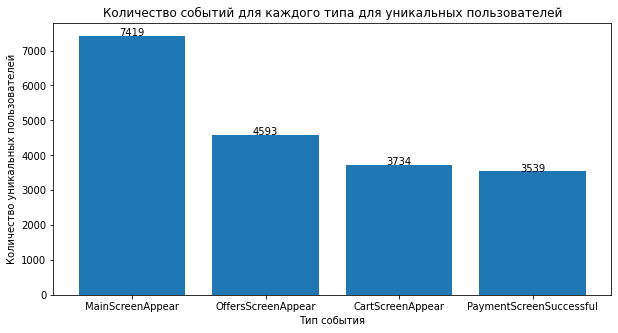

In [27]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

x = data_grouped['EventName']
y = data_grouped['UserId']
    
plt.figure(figsize = (10, 5))

plt.bar(x, y)

addlabels(x, y)
    
# Название нашего графика
plt.title("Количество событий для каждого типа для уникальных пользователей")
    
# подпишем оси
plt.xlabel("Тип события")
plt.ylabel("Количество уникальных пользователей")
    
plt.show()

MainScreenAppear является самым популярным действием. Его и выберем.

4. Считаем число пользователей, совершивших это событие в каждой из контрольных групп.

In [28]:
# Фильтруем данные по событию MainScreenAppear
main_screen_data = final_data[final_data['EventName'] == 'MainScreenAppear']

# Подсчитываем количество уникальных пользователей в группе 246
users_group_246 = main_screen_data[main_screen_data['ExpId'] == 246]['UserId'].nunique()

# Подсчитываем количество уникальных пользователей в группе 247
users_group_247 = main_screen_data[main_screen_data['ExpId'] == 247]['UserId'].nunique()

# Подсчитываем количество уникальных пользователей в группе 248
users_group_248 = main_screen_data[main_screen_data['ExpId'] == 248]['UserId'].nunique()

print(f"Количество пользователей в группе 246, совершивших событие MainScreenAppear: {users_group_246}")
print(f"Количество пользователей в группе 247, совершивших событие MainScreenAppear: {users_group_247}")
print(f"Количество пользователей в группе 248, совершивших событие MainScreenAppear: {users_group_248}")

Количество пользователей в группе 246, совершивших событие MainScreenAppear: 2450
Количество пользователей в группе 247, совершивших событие MainScreenAppear: 2476
Количество пользователей в группе 248, совершивших событие MainScreenAppear: 2493


5. Посчитаем долю пользователей, совершивших это событие.

In [29]:
# Общее количество пользователей в каждой группе
total_users_group_246 = final_data[final_data['ExpId'] == 246]['UserId'].nunique()
total_users_group_247 = final_data[final_data['ExpId'] == 247]['UserId'].nunique()
total_users_group_248 = final_data[final_data['ExpId'] == 248]['UserId'].nunique()

# Количество пользователей, совершивших событие MainScreenAppear в каждой группе
users_group_246_main_screen = main_screen_data[main_screen_data['ExpId'] == 246]['UserId'].nunique()
users_group_247_main_screen = main_screen_data[main_screen_data['ExpId'] == 247]['UserId'].nunique()
users_group_248_main_screen = main_screen_data[main_screen_data['ExpId'] == 248]['UserId'].nunique()

# Доля пользователей, совершивших событие MainScreenAppear
share_group_246 = users_group_246_main_screen / total_users_group_246
share_group_247 = users_group_247_main_screen / total_users_group_247
share_group_248 = users_group_248_main_screen / total_users_group_248

print(f"Доля пользователей в группе 246, совершивших событие MainScreenAppear: {share_group_246:.3%}")
print(f"Доля пользователей в группе 247, совершивших событие MainScreenAppear: {share_group_247:.3%}")
print(f"Доля пользователей в группе 248, совершивших событие MainScreenAppear: {share_group_248:.3%}")

Доля пользователей в группе 246, совершивших событие MainScreenAppear: 98.671%
Доля пользователей в группе 247, совершивших событие MainScreenAppear: 98.567%
Доля пользователей в группе 248, совершивших событие MainScreenAppear: 98.343%


6. Проделаем то же самое, но для других действий с помощью функции.

**1. Сформулируем гипотезу:**
Есть ли статистически значимые различия в доле пользователей, совершивших каждое событие, между двумя контрольными группами (246 и 247).

Нулевая гипотеза (H0): Доли пользователей, совершивших событие, одинаковы в группах 246 и 247.  
Альтернативная гипотеза (H1): Доли пользователей, совершивших событие, различаются в группах 246 и 247.

**2. Уровень статистической значимости:**
    Мы будем использовать уровень значимости а = 0.05. 

**3. Выберем тест:**
Для проверки различий в долях между двумя группами лучше всего подойдет z-тест для пропорций.

In [30]:
from statsmodels.stats.proportion import proportions_ztest

# Функция для проверки статистической значимости различий между группами
def check_statistical_significance(event_name):
    # Фильтруем данные по событию
    event_data = final_data[final_data['EventName'] == event_name]
    
    # Общее количество пользователей в каждой группе
    total_users_group_246 = final_data[final_data['ExpId'] == 246]['UserId'].nunique()
    total_users_group_247 = final_data[final_data['ExpId'] == 247]['UserId'].nunique()

    # Количество пользователей, совершивших событие в каждой группе
    users_group_246 = event_data[event_data['ExpId'] == 246]['UserId'].nunique()
    users_group_247 = event_data[event_data['ExpId'] == 247]['UserId'].nunique()

    # Создание массива с количеством успехов и количеством наблюдений
    successes = [users_group_246, users_group_247]
    observations = [total_users_group_246, total_users_group_247]
    
    # Z-тест для пропорций
    z_stat, p_value = proportions_ztest(successes, observations)

    # Вывод результатов
    print(f"Событие: {event_name}")
    print(f"Доля пользователей в группе 246: {users_group_246 / total_users_group_246:.3%}")
    print(f"Доля пользователей в группе 247: {users_group_247 / total_users_group_247:.3%}")
    print(f"z-статистика: {z_stat:.5f}, p-значение: {p_value:.5f}")
    print("\n" + "-"*50 + "\n")
    
    return p_value

# Список событий для анализа
events = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# Проверка для каждого события
for event in events:
    p_value = check_statistical_significance(event)

    if p_value < 0.05:
        print(f"Статистически значимые различия найдены для события {event}.")
    else:
        print(f"Различия для события {event} не являются статистически значимыми.")

Событие: MainScreenAppear
Доля пользователей в группе 246: 98.671%
Доля пользователей в группе 247: 98.567%
z-статистика: 0.31512, p-значение: 0.75267

--------------------------------------------------

Различия для события MainScreenAppear не являются статистически значимыми.
Событие: OffersScreenAppear
Доля пользователей в группе 246: 62.102%
Доля пользователей в группе 247: 60.510%
z-статистика: 1.15556, p-значение: 0.24786

--------------------------------------------------

Различия для события OffersScreenAppear не являются статистически значимыми.
Событие: CartScreenAppear
Доля пользователей в группе 246: 50.987%
Доля пользователей в группе 247: 49.283%
z-статистика: 1.20378, p-значение: 0.22868

--------------------------------------------------

Различия для события CartScreenAppear не являются статистически значимыми.
Событие: PaymentScreenSuccessful
Доля пользователей в группе 246: 48.329%
Доля пользователей в группе 247: 46.099%
z-статистика: 1.57843, p-значение: 0.11447



Исходя из результатов функции, мы наблюдаем, что различие между группами (в каждом событии) статистически достоверное.   
Разбивка по группам работает корректно.

7. Теперь поступим аналогично с группой, в которой использовался измененный шрифт. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию.

In [31]:
# Функция для проверки статистической значимости различий между контрольной и экспериментальной группами
def check_statistical_significance_with_group_248(event_name, control_group, experimental_group=248):
    # Фильтруем данные по событию
    event_data = final_data[final_data['EventName'] == event_name]
    
    # Общее количество пользователей в контрольной группе
    total_users_control = final_data[final_data['ExpId'] == control_group]['UserId'].nunique()
    # Общее количество пользователей в экспериментальной группе
    total_users_experimental = final_data[final_data['ExpId'] == experimental_group]['UserId'].nunique()

    # Количество пользователей, совершивших событие в контрольной группе
    users_control = event_data[event_data['ExpId'] == control_group]['UserId'].nunique()
    # Количество пользователей, совершивших событие в экспериментальной группе
    users_experimental = event_data[event_data['ExpId'] == experimental_group]['UserId'].nunique()

    # Создание массива с количеством успехов и количеством наблюдений
    successes = [users_control, users_experimental]
    observations = [total_users_control, total_users_experimental]
    
    # Z-тест для пропорций
    z_stat, p_value = proportions_ztest(successes, observations)

    # Вывод результатов
    print(f"Событие: {event_name}")
    print(f"Доля пользователей в контрольной группе ({control_group}): {users_control / total_users_control:.3%}")
    print(f"Доля пользователей в экспериментальной группе ({experimental_group}): {users_experimental / total_users_experimental:.3%}")
    print(f"z-статистика: {z_stat:.5f}, p-значение: {p_value:.5f}")
    print("\n" + "-"*50 + "\n")
    
    return p_value

# Список событий для анализа
events = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# Проверка для группы 246 против 248
print("Сравнение группы 246 с группой 248\n")
for event in events:
    p_value = check_statistical_significance_with_group_248(event, 246)

    if p_value < 0.05:
        print(f"Статистически значимые различия найдены для события {event} между группами 246 и 248.")
    else:
        print(f"Различия для события {event} между группами 246 и 248 не являются статистически значимыми.")

# Проверка для группы 247 против 248
print("\nСравнение группы 247 с группой 248\n")
for event in events:
    p_value = check_statistical_significance_with_group_248(event, 247)

    if p_value < 0.05:
        print(f"Статистически значимые различия найдены для события {event} между группами 247 и 248.")
    else:
        print(f"Различия для события {event} между группами 247 и 248 не являются статистически значимыми.")

Сравнение группы 246 с группой 248

Событие: MainScreenAppear
Доля пользователей в контрольной группе (246): 98.671%
Доля пользователей в экспериментальной группе (248): 98.343%
z-статистика: 0.95671, p-значение: 0.33871

--------------------------------------------------

Различия для события MainScreenAppear между группами 246 и 248 не являются статистически значимыми.
Событие: OffersScreenAppear
Доля пользователей в контрольной группе (246): 62.102%
Доля пользователей в экспериментальной группе (248): 60.394%
z-статистика: 1.24149, p-значение: 0.21442

--------------------------------------------------

Различия для события OffersScreenAppear между группами 246 и 248 не являются статистически значимыми.
Событие: CartScreenAppear
Доля пользователей в контрольной группе (246): 50.987%
Доля пользователей в экспериментальной группе (248): 48.521%
z-статистика: 1.74679, p-значение: 0.08067

--------------------------------------------------

Различия для события CartScreenAppear между гр

8. Сравним результаты с объединённой контрольной группой и исследуем полученные результаты.

In [32]:
# Функция для проверки статистической значимости различий между объединённой контрольной группой и экспериментальной группой
def check_statistical_significance_with_combined_control(event_name, experimental_group=248):
    # Фильтруем данные по событию
    event_data = final_data[final_data['EventName'] == event_name]
    
    # Общее количество пользователей в объединённой контрольной группе (246 + 247)
    total_users_control = final_data[final_data['ExpId'].isin([246, 247])]['UserId'].nunique()
    # Общее количество пользователей в экспериментальной группе
    total_users_experimental = final_data[final_data['ExpId'] == experimental_group]['UserId'].nunique()

    # Количество пользователей, совершивших событие в объединённой контрольной группе (246 + 247)
    users_control = event_data[event_data['ExpId'].isin([246, 247])]['UserId'].nunique()
    # Количество пользователей, совершивших событие в экспериментальной группе
    users_experimental = event_data[event_data['ExpId'] == experimental_group]['UserId'].nunique()

    # Создание массива с количеством успехов и количеством наблюдений
    successes = [users_control, users_experimental]
    observations = [total_users_control, total_users_experimental]
    
    # Z-тест для пропорций
    z_stat, p_value = proportions_ztest(successes, observations)

    # Вывод результатов
    print(f"Событие: {event_name}")
    print(f"Доля пользователей в объединённой контрольной группе (246 + 247): {users_control / total_users_control:.3%}")
    print(f"Доля пользователей в экспериментальной группе ({experimental_group}): {users_experimental / total_users_experimental:.3%}")
    print(f"z-статистика: {z_stat:.5f}, p-значение: {p_value:.5f}")
    print("\n" + "-"*50 + "\n")
    
    return p_value

# Список событий для анализа
events = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# Проверка для объединённой контрольной группы против группы 248
print("Сравнение объединённой контрольной группы (246 + 247) с группой 248\n")
for event in events:
    p_value = check_statistical_significance_with_combined_control(event)

    if p_value < 0.05:
        print(f"Статистически значимые различия найдены для события {event} между объединённой контрольной группой и группой 248.")
    else:
        print(f"Различия для события {event} между объединённой контрольной группой и группой 248 не являются статистически значимыми.")

Сравнение объединённой контрольной группы (246 + 247) с группой 248

Событие: MainScreenAppear
Доля пользователей в объединённой контрольной группе (246 + 247): 98.619%
Доля пользователей в экспериментальной группе (248): 98.343%
z-статистика: 0.93718, p-значение: 0.34867

--------------------------------------------------

Различия для события MainScreenAppear между объединённой контрольной группой и группой 248 не являются статистически значимыми.
Событие: OffersScreenAppear
Доля пользователей в объединённой контрольной группе (246 + 247): 61.301%
Доля пользователей в экспериментальной группе (248): 60.394%
z-статистика: 0.76239, p-значение: 0.44583

--------------------------------------------------

Различия для события OffersScreenAppear между объединённой контрольной группой и группой 248 не являются статистически значимыми.
Событие: CartScreenAppear
Доля пользователей в объединённой контрольной группе (246 + 247): 50.130%
Доля пользователей в экспериментальной группе (248): 48.5

9. Уровень значимости и число проверок:

    **Выбранный уровень значимости:** В предыдущих проверках, как правило, использовался уровень значимости 0.05. Однако, поскольку в задаче рассматривается множество проверок, возможно, было бы полезно рассмотреть уровень значимости 0.1 для определения потенциальных эффектов с определенным уровнем доверия.
    **Количество проверок:** Всего было выполнено 16 проверок статистических гипотез (по 4 события на 4 сравнения).


10. Оценка уровня значимости:

    Если использовать уровень значимости 0.1, это означает, что в 10% случаев можно ошибочно отклонить нулевую гипотезу. Однако при 20 проверках вероятность ложноположительного результата увеличивается. Чтобы снизить риск ошибок первого рода, стоит либо снизить уровень значимости (например, до 0.05) либо применить коррекцию для множественных тестов, такую как метод Бонферрони.

11. Поскольку целью теста было проверить, не вызовут ли изменения шрифта негативную реакцию у пользователей и, следовательно, не уменьшатся ли ключевые метрики, такие как: количество пользователей, проходящих через основные этапы взаимодействия с приложением (просмотр главного экрана, просмотр предложений, добавление товара в корзину, успешная оплата).

    Проведённый анализ показал, что ни в одной из проверок (как между контрольными группами 246 и 247 и экспериментальной группой 248, так и между объединённой контрольной группой (246 + 247) и экспериментальной группой 248) не было обнаружено статистически значимых различий в доле пользователей, совершивших ключевые события.

12. **Отсутствие значимых различий между контрольными группами и экспериментальной группой по всем ключевым событиям** означает, что изменение шрифта не привело к значимым изменениям в поведении пользователей. Это свидетельствует о том, что пользователи благоприятно отнеслись к новому шрифту и продолжили использовать приложение в привычном объёме.  
    **Отсутствие негативного эффекта (снижения доли пользователей на этапах воронки)** позволяет предположить, что внедрение нового шрифта не ухудшит пользовательский опыт и, следовательно, его можно внедрять.
        
   **Вывод по A/B тесту:** На основе проведенного A/B теста можно сделать вывод, что изменения шрифта не оказывают негативного влияния на поведение пользователей в приложении. Рекомендуется внедрить новый шрифт, так как это изменение не нарушает пользовательский опыт и может способствовать обновлению визуального стиля без ущерба для ключевых метрик.

### Итоги
Общий вывод по проекту:
Цель проекта заключалась в исследовании пути пользователей до покупки и влиянии изменения шрифта на их поведение.

Анализ воронки пользователей показал, что только 47.7% пользователей доходят до этапа успешной оплаты. Основные потери происходят на этапе перехода от главного экрана к экрану предложений (61.91% пользователей). Несмотря на это, большинство пользователей, добавивших товар в корзину, успешно завершают покупку (94.78%).

Для оценки влияния нового шрифта был проведен A/B тест. Участники были разделены на три группы: две контрольные группы (246 и 247) и одну экспериментальную (248) с новым шрифтом. В результате анализа статистически значимых различий между контрольными группами и группой с измененным шрифтом по ключевым событиям не было обнаружено. Это указывает на то, что новый шрифт не оказывает значимого влияния на поведение пользователей.

Заключение: Новый шрифт можно внедрить, так как его использование не ухудшает пользовательский опыт и не влияет на ключевые метрики.